# Continuous Control Project

In [1]:
import sys
sys.path.append('./code')
from unityagents import UnityEnvironment
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import torch

## Training the Agent

In [2]:
env = UnityEnvironment(file_name = "Reacher_Linux/Reacher.x86_64")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
action_size = brain.vector_action_space_size

env_info = env.reset(train_mode=True)[brain_name]     # reset the environment
num_agents = len(env_info.agents)
state = env_info.vector_observations[0]
state_size = state.shape[0]


### Train 
from ddpg_agent import Agent
agent = Agent(state_size=state_size, action_size=action_size, random_seed=0)

def ddpg(n_episodes=400, max_t=1000):
    scores_deque = deque(maxlen=100)   # most revent 100 scores 
    scores = []                        # list containing scores from each episode
    scores_mean = []                   # tracking the mean of deque
    success = False
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]     # reset the environment
        state = env_info.vector_observations[0]
        agent.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state)
            env_info = env.step([action])[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]          
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_deque.append(score)
        scores.append(score)
        scores_mean.append(np.mean(scores_deque))
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, np.mean(scores_deque), score), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'models/checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'models/checkpoint_critic.pth')
        if np.mean(scores_deque) > 30 and not success:
            print('Target achieved after {:d} episodes'.format(i_episode))
            success = True

    torch.save(agent.actor_local.state_dict(), 'models/actor_opt.pth')
    torch.save(agent.critic_local.state_dict(), 'models/critic_opt.pth')     
    return scores, scores_mean

scores, scores_mean = ddpg()
env.close()





INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 
/home/dimitrios/anaconda3/envs/ai/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 100	Average Score: 4.23	Score: 7.22
Episode 200	Average Score: 17.30	Score: 37.77
Episode 254	Average Score: 30.18	Score: 35.47Target achieved after 254 episodes
Episode 300	Average Score: 35.11	Score: 39.51
Episode 400	Average Score: 33.67	Score: 38.93


## Plotting Scores

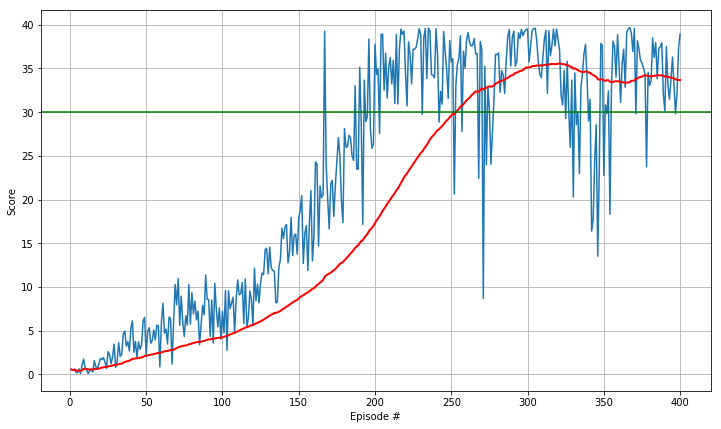

In [16]:
fig = plt.figure(figsize=(12,7))
plt.grid()
plt.plot(np.arange(1, len(scores)+1), scores)
plt.plot(np.arange(1, len(scores)+1), scores_mean,'r',  linewidth=2)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.axhline(y=30, color='g')
plt.show()